In [1]:
import tensorflow as tf
from pathlib import Path
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Create the dataset
data_dir = Path('./dataset/mudkip/')

img_height = 200
img_width = 200

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed = 258, # mudkips pokedex number
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed = 258, # mudkips pokedex number
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 130 files belonging to 2 classes.
Using 104 files for training.
Found 130 files belonging to 2 classes.
Using 26 files for validation.


In [ ]:
# Visualize the first 15 items in the dataset
# TODO: Update this to show more eventually when the datasets are bigger
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# Create model
# TODO: mess around and learn more about the layers
# The number of classes may differ depending on the hunt and how it is compiled
# It will either be 2 (target_normal, target_shiny) or 4 (target_normal, target_shiny, not_target_normal, not_target_shiny) 
number_of_classes = len(class_names)

data_augmentation = tf.keras.models.Sequential()
data_augmentation.add(tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)))
data_augmentation.add(tf.keras.layers.RandomRotation(0.1))
data_augmentation.add(tf.keras.layers.RandomZoom(0.1))

model = tf.keras.models.Sequential()
model.add(data_augmentation)
model.add(tf.keras.layers.Rescaling(1/.255, input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(number_of_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

Epoch 1/10
4/4 [==============================] - 4s 552ms/step - loss: 3140.7900 - accuracy: 0.4712 - val_loss: 820.6655 - val_accuracy: 0.3846
Epoch 2/10
4/4 [==============================] - 2s 503ms/step - loss: 396.7654 - accuracy: 0.5288 - val_loss: 7.6370 - val_accuracy: 0.7692
Epoch 3/10
4/4 [==============================] - 2s 485ms/step - loss: 34.1592 - accuracy: 0.5288 - val_loss: 7.2196 - val_accuracy: 0.6538
Epoch 4/10
4/4 [==============================] - 2s 509ms/step - loss: 16.8639 - accuracy: 0.6058 - val_loss: 25.2358 - val_accuracy: 0.4615
Epoch 5/10
4/4 [==============================] - 2s 509ms/step - loss: 6.2940 - accuracy: 0.7212 - val_loss: 3.9678 - val_accuracy: 0.7692
Epoch 6/10
4/4 [==============================] - 2s 497ms/step - loss: 7.2058 - accuracy: 0.6827 - val_loss: 1.6257 - val_accuracy: 0.8462
Epoch 7/10
4/4 [==============================] - 2s 501ms/step - loss: 1.4940 - accuracy: 0.8846 - val_loss: 9.4441 - val_accuracy: 0.5769
Epoch 8/10

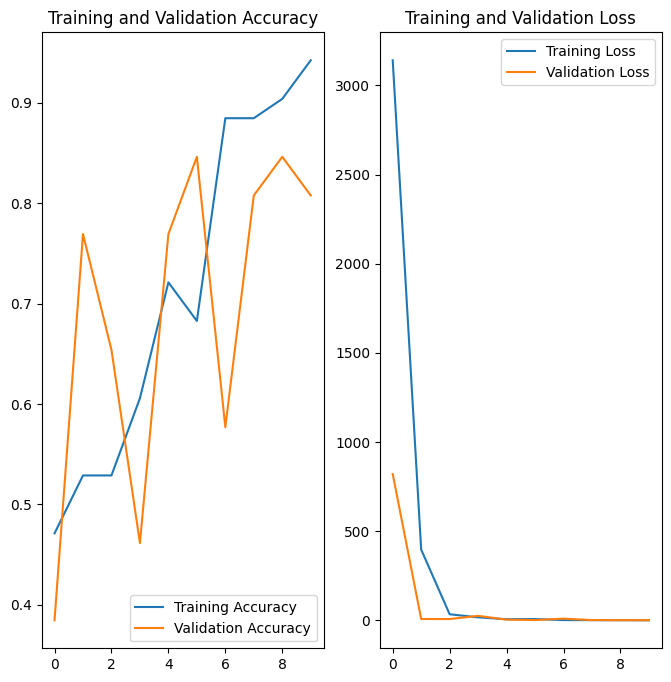

In [8]:
# Train model
epochs = 10
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 42ms/step
This image most likely is target_normal with a 99.80 percent confidence


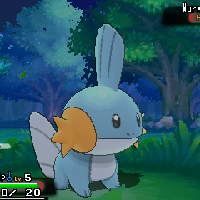

In [58]:
# Test the model with a single image
test_path = Path('./test_imgs/mudkip/40.png')

img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width), keep_aspect_ratio=True)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))
img

In [65]:
# Test the model in a batch
test_path = Path('./test_imgs/mudkip/')
actual = ['target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny',
          'target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny',
          'target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',
          'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny', 'target_shiny',
          'target_normal', 'target_normal', 'target_normal', 'target_normal', 'target_normal',]
predicts = []

for file in test_path.iterdir():
    img = tf.keras.utils.load_img(file, target_size=(img_height, img_width), keep_aspect_ratio=True)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicts.append(class_names[np.argmax(score)])
    print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))

overall_score = 0
normal_score = 0
shiny_score = 0
for i in range(40):
    if actual[i] == predicts[i]:
        overall_score += 1
        if actual[i] == 'target_normal':
            normal_score += 1
        elif actual[i] == 'target_shiny':
            shiny_score += 1

overall_percent = (overall_score / len(actual)) * 100
normal_percent = (normal_score / (len(actual) / 2)) * 100
shiny_percent = (shiny_score / (len(actual) / 2)) * 100

print(f"Overall Score: {overall_percent}% ({overall_score}/{len(actual)})")
print(f"Normal Score: {normal_percent}% ({normal_score}/{len(actual) / 2})")
print(f"Shiny Score: {shiny_percent}% ({shiny_score}/{len(actual) / 2})")

1/1 [==============================] - 0s 30ms/step
This image most likely is target_normal with a 96.58 percent confidence
1/1 [==============================] - 0s 39ms/step
This image most likely is target_normal with a 99.00 percent confidence
1/1 [==============================] - 0s 33ms/step
This image most likely is target_normal with a 99.96 percent confidence
1/1 [==============================] - 0s 30ms/step
This image most likely is target_normal with a 99.31 percent confidence
1/1 [==============================] - 0s 29ms/step
This image most likely is target_normal with a 95.91 percent confidence
1/1 [==============================] - 0s 30ms/step
This image most likely is target_shiny with a 100.00 percent confidence
1/1 [==============================] - 0s 29ms/step
This image most likely is target_shiny with a 100.00 percent confidence
1/1 [==============================] - 0s 35ms/step
This image most likely is target_shiny with a 100.00 percent confidence
1/1 [===

In [ ]:
# TODO: Save the model